# PDE Solution

In [31]:
import torch
from torch import nn
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pinn.lib import SchrodingerData, SchrodingerModel, get_loss, Util

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [33]:
import os

os.makedirs("Data", exist_ok=True)

import requests

url = "https://github.com/maziarraissi/PINNs/raw/master/main/Data/NLS.mat"
r = requests.get(url)

with open("Data/NLS.mat", "wb") as f:
    f.write(r.content)

print("Downloaded NLS.mat to Data/NLS.mat")

Downloaded NLS.mat to Data/NLS.mat


In [34]:
data = scipy.io.loadmat('Data/NLS.mat')

t_np = data['tt'].flatten()[:,None]
x_np = data['x'].flatten()[:,None]
Exact = data['uu']
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)

In [35]:
t_np.shape, x_np.shape, Exact.shape

((201, 1), (256, 1), (256, 201))

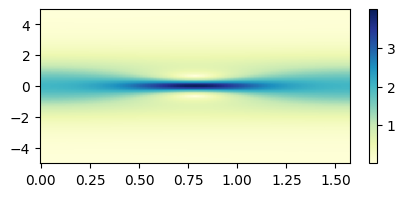

In [36]:
T_np, X_np = np.meshgrid(t_np.squeeze(), x_np.squeeze())

plt.figure(figsize=(5,2))
plt.pcolormesh(T_np, X_np, np.abs(Exact), cmap="YlGnBu")
plt.colorbar()
plt.show()

In [37]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

In [38]:
util = Util()
schrodinger_data = SchrodingerData(util,
                                   Exact,
                                   x_np,
                                   n_data=50,
                                   n_boundary=50,
                                   n_collocation=20000,
                                   t_bound=[0, torch.pi / 2],
                                   x_bound=[-5, 5]
                                  )

In [39]:
epochs = 100
schrodinger_model = SchrodingerModel(n_input=2,n_layer=3, n_out=2,                                   t_bound=[0, torch.pi / 2],
                                   x_bound=[-5, 5])
optimizer = torch.optim.Adam(schrodinger_model.parameters())
schrodinger_model.to(device)

SchrodingerModel(
  (first): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Tanh()
  )
  (hidden): Sequential(
    (0): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): Tanh()
    )
  )
  (last): Linear(in_features=100, out_features=2, bias=True)
)

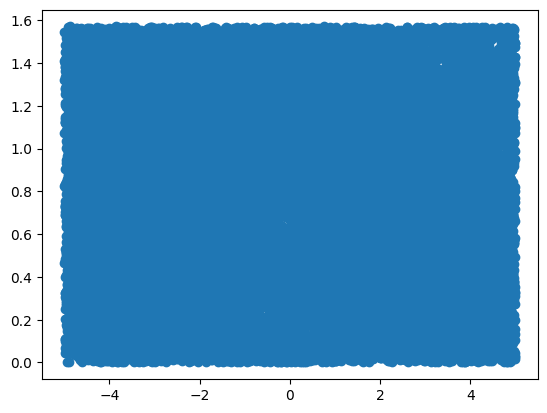

In [40]:
x, t = schrodinger_data.sample_collocation()
plt.scatter(x, t)

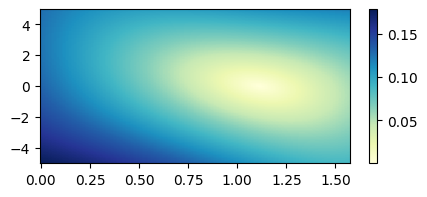

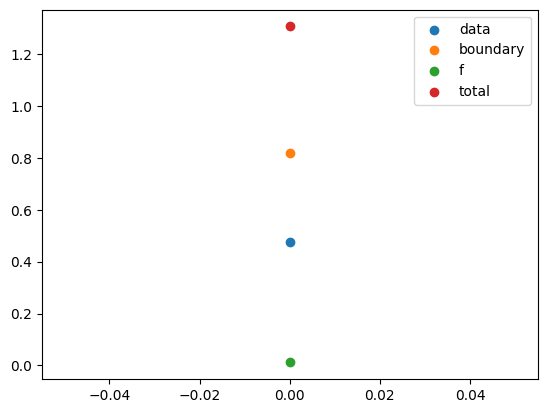

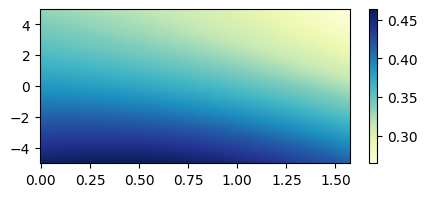

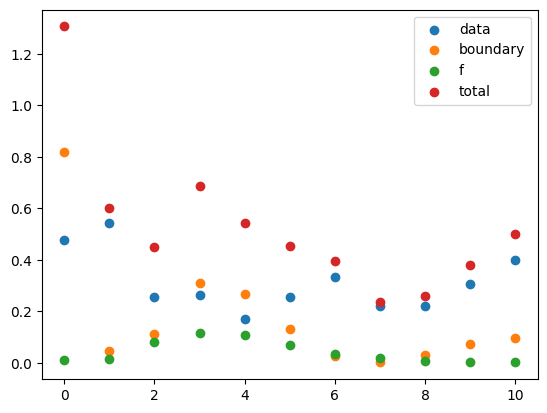

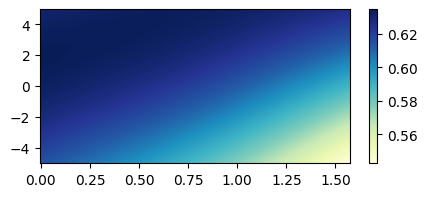

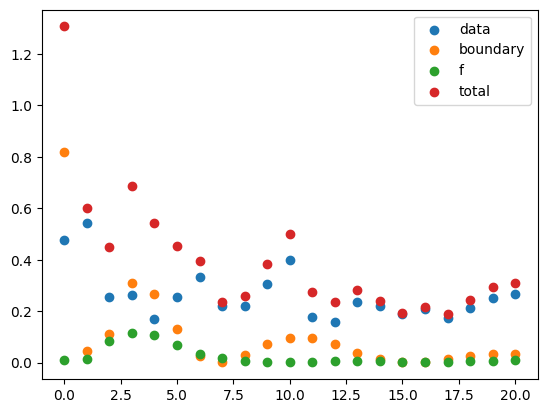

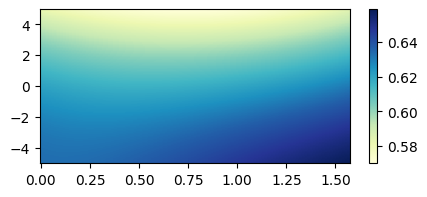

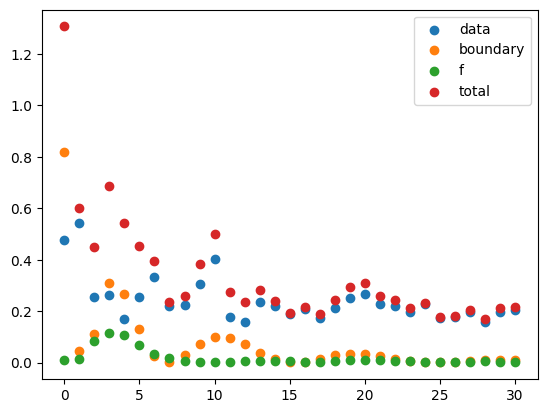

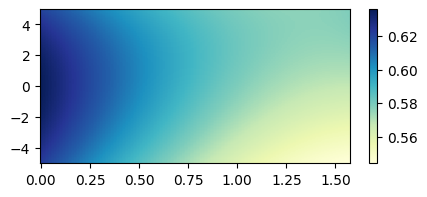

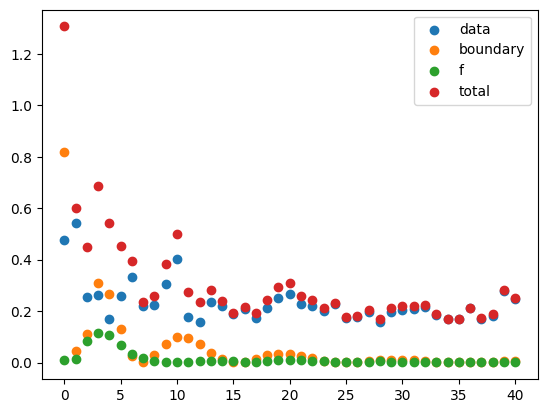

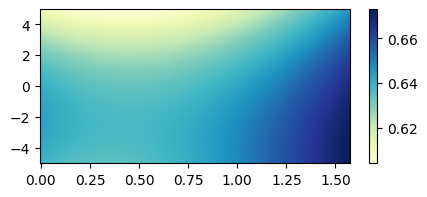

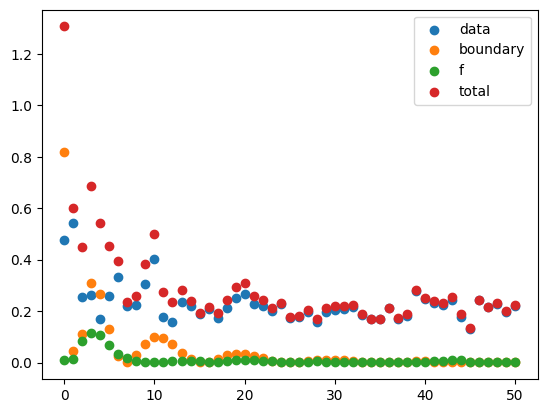

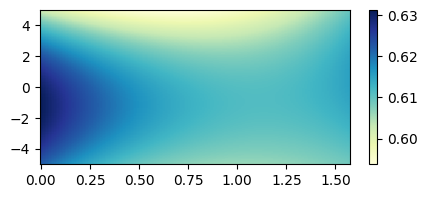

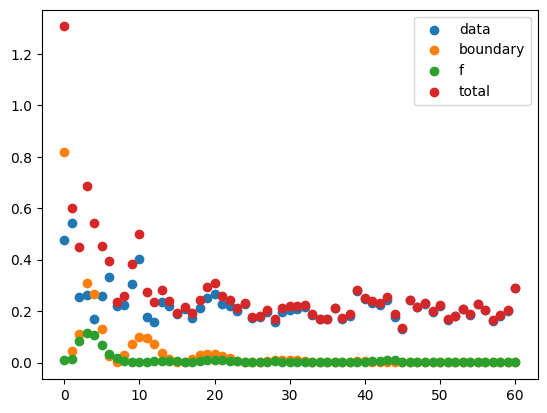

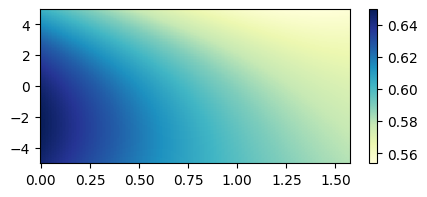

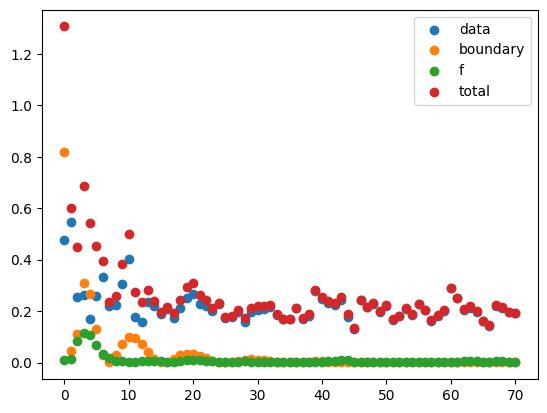

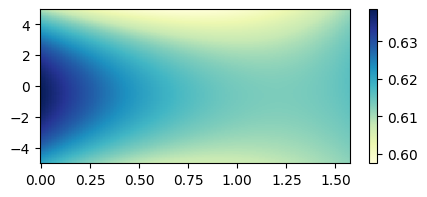

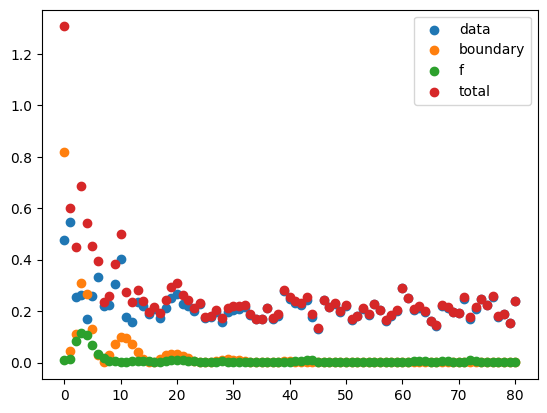

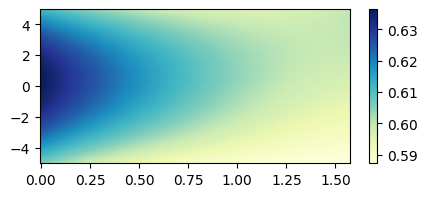

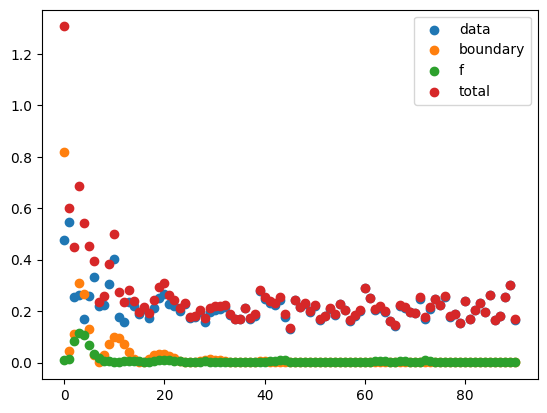

In [ ]:
data_losses = []
boundary_losses = []
f_losses = []
for i in range(epochs):
    optimizer.zero_grad()

    data_loss, boundary_loss, f_loss = get_loss(schrodinger_model, schrodinger_data)
    loss = data_loss + boundary_loss + f_loss

    loss.backward()

    optimizer.step()

    data_losses.append(data_loss.item())
    boundary_losses.append(boundary_loss.item())
    f_losses.append(f_loss.item())

    if i % max(1, epochs // 10) == 0:
        T_np, X_np = np.meshgrid(t_np.flatten(), x_np.flatten())
        pairs = torch.tensor(np.column_stack([X_np.ravel(), T_np.ravel()]), device=device, dtype=torch.float)

        result = schrodinger_model(torch.tensor(X_np.ravel(), dtype=torch.float), torch.tensor(T_np.ravel(), dtype=torch.float))

        np_result = np.abs(result.detach().cpu().numpy()[:,1] * 1j + result.detach().cpu().numpy()[:,0])

        plt.figure(figsize=(5,2))
        plt.pcolormesh(T_np, X_np, np_result.reshape(x_np.shape[0], t_np.shape[0]), cmap="YlGnBu")
        plt.colorbar()
        plt.show()
        plt.scatter(np.arange(len(data_losses)), np.array(data_losses), label="data")
        plt.scatter(np.arange(len(boundary_losses)), np.array(boundary_losses), label="boundary")
        plt.scatter(np.arange(len(f_losses)), np.array(f_losses), label="f")
        plt.scatter(np.arange(len(boundary_losses)), np.array(boundary_losses) + np.array(data_losses) + np.array(f_losses), label="total")
        plt.legend()
        plt.show()



In [43]:
checkpoint_path = "weights/base_pinn.pt"
# torch.save({
#     "model_state_dict": schrodinger_model.state_dict(),
#     "optimizer_state_dict": optimizer.state_dict()
# }, checkpoint_path)

In [44]:
epochs = 1

checkpoint = torch.load(checkpoint_path, map_location=device)
schrodinger_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

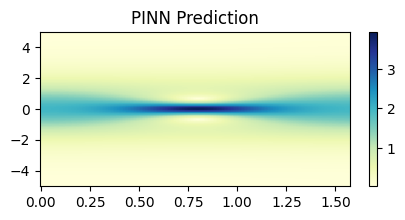

In [45]:
result = schrodinger_model(torch.tensor(X_np.ravel(), dtype=torch.float), torch.tensor(T_np.ravel(), dtype=torch.float))
np_result = np.abs(result.detach().cpu().numpy()[:,1] * 1j + result.detach().cpu().numpy()[:,0])

plt.figure(figsize=(5,2))
plt.pcolormesh(T_np, X_np, np_result.reshape(x_np.shape[0], t_np.shape[0]), cmap="YlGnBu")
plt.colorbar()
plt.title("PINN Prediction")
plt.show()

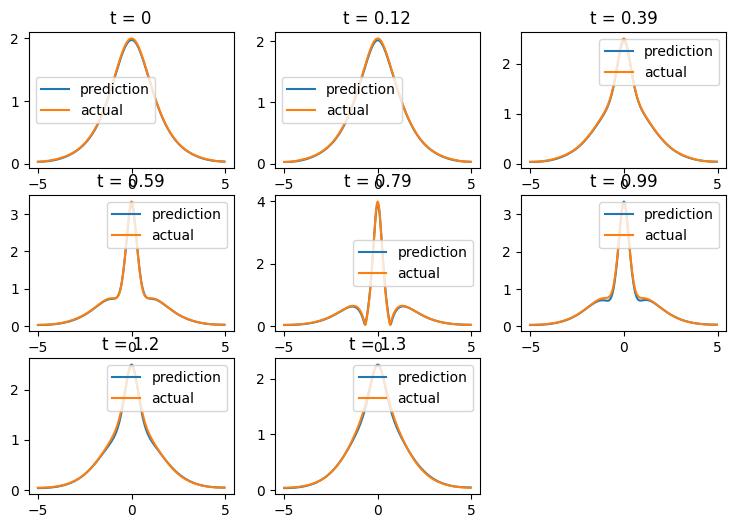

In [46]:
plt.figure(figsize=(9,6))
T_np, X_np = np.meshgrid(t_np.flatten(), x_np.flatten())
pairs = torch.tensor(np.column_stack([X_np.ravel(), T_np.ravel()]), dtype=torch.float, device=device)

result = schrodinger_model(torch.tensor(X_np.ravel(), dtype=torch.float), torch.tensor(T_np.ravel(), dtype=torch.float))

np_result = np.abs(result.detach().cpu().numpy()[:,1] * 1j + result.detach().cpu().numpy()[:,0])
for idx, t_evaluation in enumerate([0, 0.12, 0.39, 0.59, 0.79, 0.99, 1.2, 1.3]):
    
    mask = (pairs[:,1] == t_np[ int(t_evaluation / (np.pi / 2) * 201),0])
    x_coord = pairs[mask][:,0].detach()
    y_coord = torch.abs(result[mask,0] + result[mask,1] * 1j).detach()
    plt.subplot(3, 3, idx + 1)
    plt.plot(x_coord, y_coord, label="prediction")
    plt.plot(x_coord, np.abs(Exact[:,int(t_evaluation / (np.pi / 2) * 201)]), label="actual")
    plt.legend()
    plt.title("t = " + str(t_evaluation))

plt.show()